# Analysis of Sphere packing efficeincy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # For calculating QPSK decoding
import dill
from itertools import product, cycle

import tensorflow.keras.backend as K

System Configuration

In [13]:
blkSize     = 4
chDim       = 2

# Input
inVecDim   = 2 ** blkSize  # 1-hot vector length for block
encDim = 2*chDim

SNR_range_dB = np.arange( 0.0, 11.0, 1.0 )

one_hot_code = np.eye(inVecDim)

## Traditional Systems

### QAM

In [14]:
qam_map = np.array(list(map(list, product([-1, +1], repeat=blkSize))))
qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "QAM Avg. Tx Power:", qam_sym_pow )

noisePower = qam_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim)

QAM Avg. Tx Power: 4.0


### Agrell Map

In [15]:
agrell_map = []
if blkSize==2 and chDim==1:
    agrell_map = np.array([
        [ -1.0, -1.0 ],
        [ -1.0, 1.0 ],
        [ 1.0, -1.0 ],
        [ 1.0, 1.0 ]
    ])
elif blkSize==4 and chDim==2:
    agrell_map = np.array([
        [2.148934030042627, 0.0, 0.0, 0.0],
        [0.7347204676695321, 1.4142135623730951, 0.0, 0.0],
        [0.7347204676695321, -1.4142135623730951, 0.0, 0.0],
        [0.7347204676695321, 0.0, 1.4142135623730951, 0.0],
        [0.7347204676695321, 0.0, -1.4142135623730951, 0.0],
        [0.7347204676695321, 0.0, 0.0, 1.4142135623730951],
        [0.7347204676695321, 0.0, 0.0, -1.4142135623730951],
        [-0.6174729817844246, 1.0, 1.0, 1.0],
        [-0.6174729817844246, 1.0, 1.0, -1.0],
        [-0.6174729817844246, 1.0, -1.0, 1.0],
        [-0.6174729817844246, 1.0, -1.0, -1.0],
        [-0.6174729817844246, -1.0, 1.0, 1.0],
        [-0.6174729817844246, -1.0, 1.0, -1.0],
        [-0.6174729817844246, -1.0, -1.0, 1.0],
        [-0.6174729817844246, -1.0, -1.0, -1.0],
        [-1.6174729817844242, 0.0, 0.0, 0.0]
    ])
elif blkSize==8 and chDim==4:
    agrell_map = np.array([
        [ -256.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -370.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -373.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 373.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 0.0, -256.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -370.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -373.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 373.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 256.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ] ])
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "Agrell Avg. Tx Power:", agrell_sym_pow )

noisePower = agrell_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim)

Agrell Avg. Tx Power: 3.095200273238941


### Compute Metrics

QAM

In [16]:
qam_map = np.array(list(map(list, product([-1, +1], repeat=blkSize))))

qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "QAM Avg. Tx Power:", qam_sym_pow )

qam_d_min = np.unique(cdist(qam_map,qam_map))[1]
print("d_min:", qam_d_min )

qam_en = qam_sym_pow / (qam_d_min**2)
print("En:", qam_en)

QAM Avg. Tx Power: 4.0
d_min: 2.0
En: 1.0


Agrell

In [17]:
agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "Agrell Avg. Tx Power:", agrell_sym_pow )

agrell_dmin = np.unique(cdist(agrell_map,agrell_map))[1]
print("d_min:", agrell_dmin )

agrell_en = agrell_sym_pow / (agrell_dmin**2)
print("En:", agrell_en)

Agrell Avg. Tx Power: 3.095200273238941
d_min: 1.9999999999999998
En: 0.7738000683097355


## Deep Learning Model

In [18]:
from CommVAE import CommVAE1hot
from AEOshea import AEOshea1hot

Specify models to analyze

In [19]:
model_summary = {}
results = {}

# if blkSize==8 and chDim==4:
#     model_summary = { 
#         "AWGN ($\sigma_n^2=0.4$)": "./models_08x04/rbf_awgn_64_32_16_n040_summary.dil",
#         "AWGN ($\sigma_n^2=0.8$)": "./models_08x04/rbf_awgn_64_32_16_n080_summary.dil",
#         "AWGN ($\sigma_n^2=1.2$)": "./models_08x04/rbf_awgn_64_32_16_n120_summary.dil",
#         "RBF ($\sigma_n^2=0.4$)": "./models_08x04/rbf_rbf_64_32_16_n040_summary.dil",
#         "RBF ($\sigma_n^2=0.8$)": "./models_08x04/rbf_rbf_64_32_16_n080_summary.dil",
#         "RBF ($\sigma_n^2=1.2$)": "./models_08x04/rbf_rbf_64_32_16_n120_summary.dil",
#         "Oshea ($4dB$)": "./models_08x04/rbf_oshea_64_32_16_04dB_summary.dil",
#         "Oshea ($10dB$)": "./models_08x04/rbf_oshea_64_32_16_10dB_summary.dil"
#     }
# elif blkSize==4 and chDim==2:
#     model_summary = {
#         "AWGN($\sigma_n^2=0.2$)": "./models_04x02/rbf_awgn_64_32_16_n020_summary.dil",
#         "AWGN($\sigma_n^2=0.4$)": "./models_04x02/rbf_awgn_64_32_16_n040_summary.dil",
#         "AWGN($\sigma_n^2=0.6$)": "./models_04x02/rbf_awgn_64_32_16_n060_summary.dil",
#         "RBF($\sigma_n^2=0.2$)": "./models_04x02/rbf_rbf_64_32_16_n020_summary.dil",
#         "RBF($\sigma_n^2=0.4$)": "./models_04x02/rbf_rbf_64_32_16_n040_summary.dil",
#         "RBF($\sigma_n^2=0.6$)": "./models_04x02/rbf_rbf_64_32_16_n060_summary.dil",
#         "Oshea ($4dB$)": "./models_04x02/rbf_oshea_64_32_16_04dB_summary.dil",
#         "Oshea ($10dB$)": "./models_04x02/rbf_oshea_64_32_16_10dB_summary.dil"
#     }
# elif blkSize==2 and chDim==1:
#     model_summary = {
        
#     }
# else:
#     raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

if blkSize==8 and chDim==4:
    model_summary = { 
        "[1]": "./models_08x04/rbf_oshea_64_32_16_10dB_summary.dil",
#         "AWGN ($\sigma_n^2=0.4$)": "./models_08x04/rbf_awgn_64_32_16_n040_summary.dil",
        "Proposed: Trained with (19)": "./models_08x04/rbf_awgn_64_32_16_n080_summary.dil",
#         "AWGN ($\sigma_n^2=1.2$)": "./models_08x04/rbf_awgn_64_32_16_n120_summary.dil",
#         "RBF ($\sigma_n^2=0.4$)": "./models_08x04/rbf_rbf_64_32_16_n040_summary.dil",
        "Proposed: Trained with (23)": "./models_08x04/rbf_rbf_64_32_16_n080_summary.dil",
#         "RBF ($\sigma_n^2=1.2$)": "./models_08x04/rbf_rbf_64_32_16_n120_summary.dil",
#         "Oshea ($4dB$)": "./models_08x04/rbf_oshea_64_32_16_04dB_summary.dil",
    }
elif blkSize==4 and chDim==2:
    model_summary = {
        "[1]": "./models_04x02/rbf_oshea_64_32_16_10dB_summary.dil",
#         "AWGN($\sigma_n^2=0.2$)": "./models_04x02/rbf_awgn_64_32_16_n020_summary.dil",
        "Proposed: Trained with (19)": "./models_04x02/rbf_awgn_64_32_16_n040_summary.dil",
#         "AWGN($\sigma_n^2=0.6$)": "./models_04x02/rbf_awgn_64_32_16_n060_summary.dil",
#         "RBF($\sigma_n^2=0.2$)": "./models_04x02/rbf_rbf_64_32_16_n020_summary.dil",
        "Proposed: Trained with (23)": "./models_04x02/rbf_rbf_64_32_16_n040_summary.dil",
#         "RBF($\sigma_n^2=0.6$)": "./models_04x02/rbf_rbf_64_32_16_n060_summary.dil",
#         "Oshea ($4dB$)": "./models_04x02/rbf_oshea_64_32_16_04dB_summary.dil",
    }
elif blkSize==2 and chDim==1:
    model_summary = {
        "[1]": "./models_02x01/rbf_oshea_64_32_16_10dB_summary.dil",
        "Proposed: Trained with (19)": "./models_02x01/rbf_awgn_64_32_16_n020_summary.dil",
        "Proposed: Trained with (23)": "./models_02x01/rbf_rbf_64_32_16_n020_summary.dil",
    }
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

For each of the model, compute $E_n$

In [20]:
for (model_exp,summary_file) in model_summary.items():
    summary_data = {}
    file_prefix = None
    # Load file
    results[model_exp] = {}
    with open(summary_file, "rb") as file:
        file_prefix = summary_file.split("_summary.dil")[0]
        summary_data = dill.load(file)
    for (modelid,(sym_pow,bler)) in summary_data.items():
        config_file = file_prefix + "_" + modelid + ".dil"
        config = {}
        model = None
        with open(config_file, "rb") as cfg_file:
            config = dill.load(cfg_file)
        if 'obj_fn' in config:    # obj_fn is there only for proposed CommVAE
            print(config_file, "    CommVAE")
            model = CommVAE1hot()
        else:
            print(config_file, "    AEOshea")
            model = AEOshea1hot()
        model.load_model(file_prefix+"_"+modelid)
        # Compute the Tx power and packing density
        dl_map = model.encode(one_hot_code)
        dl_sym_pow = np.mean(np.sum(dl_map*dl_map,axis=1))
        dl_d_min = np.unique(cdist(dl_map,dl_map))[1]
        dl_en = dl_sym_pow / (dl_d_min**2)
        print("sym_pow:", sym_pow, "    Model: ", dl_sym_pow, dl_d_min, dl_en, "    Pilots :", model.pilot_sym)
        assert(np.abs(sym_pow-dl_sym_pow)<1e-3) # To make sure that we loaded right weights to model
        # save the results
        results[model_exp][modelid] = dl_en
        # Clear Session and Model
        K.clear_session()
        del model

./models_04x02/rbf_oshea_64_32_16_10dB_20190321021005.dil     AEOshea
sym_pow: 4.0103226     Model:  4.0103226 1.8678458098603916 1.1494689954849178     Pilots : [1.00128949 1.00128949]
./models_04x02/rbf_oshea_64_32_16_10dB_20190321021421.dil     AEOshea
sym_pow: 4.021494     Model:  4.021494 1.8041060599938958 1.2355584207892663     Pilots : [1.00268314 1.00268314]
./models_04x02/rbf_oshea_64_32_16_10dB_20190321021835.dil     AEOshea
sym_pow: 4.016215     Model:  4.016215 1.8169302776635188 1.2165792730256213     Pilots : [1.00202481 1.00202481]
./models_04x02/rbf_oshea_64_32_16_10dB_20190321022254.dil     AEOshea
sym_pow: 4.0436974     Model:  4.0436974 1.8158547090988673 1.2263556913828362     Pilots : [1.00544733 1.00544733]
./models_04x02/rbf_oshea_64_32_16_10dB_20190321022708.dil     AEOshea
sym_pow: 4.037722     Model:  4.037722 1.8163475654818217 1.2238790867622538     Pilots : [1.0047042 1.0047042]
./models_04x02/rbf_oshea_64_32_16_10dB_20190321023126.dil     AEOshea
sym_pow:

Plot $E_n$ distribution

[1]     Min: 1.0957113758453254     Max: 1.4242162083206868
Proposed: Trained with (19)     Min: 0.9442138580261565     Max: 1.1523691471870963
Proposed: Trained with (23)     Min: 1.0544938823083154     Max: 1.2040457387710786


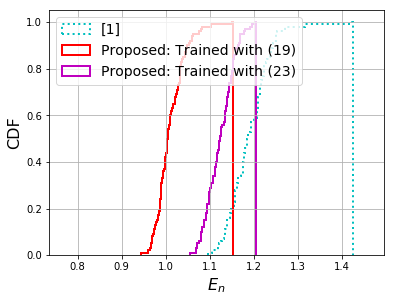

In [21]:
# colors = cycle(['b', 'g', 'r', 'c', 'm', 'y'])
# plt.figure(figsize=(8,6))
# selected_max_en = []
# for (model_exp,density_data) in results.items():
#     d = np.array([ en for (_,en) in density_data.items() ])
# #     if np.max(d) < 1.4*qam_en: # Avoid un-necessary models
#     plt.hist(d, bins=100, cumulative=True, histtype="step", label=model_exp, 
#              color=next(colors), linewidth=2, linestyle=":" if "Oshea" in model_exp else "-")
#     selected_max_en.append(np.max(d)) if np.max(d) < 1.5*qam_en else None
#     print(model_exp, "    Min:", np.min(d), "    Max:", np.max(d))
# plt.xlim([0.95*agrell_en,np.max(selected_max_en)*1.05])
# plt.plot([qam_en,qam_en], [0,100], linewidth=6, label="QAM", color=next(colors), linestyle=":")
# plt.plot([agrell_en,agrell_en], [0,100], linewidth=6, label="Agrell", color=next(colors), linestyle=":")
# plt.grid()
# plt.legend(loc='upper left', prop={'size':14})
# plt.title("Packing Density for ({},{})".format(blkSize,chDim), fontdict={'fontsize':18})
# plt.xlabel("$E_n$", fontdict={'fontsize':16})
# plt.ylabel("Distribution", fontdict={'fontsize':16})
# plt.savefig("output.eps", format='eps', bbox_inches='tight')

# colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
colors = cycle(['c', 'r', 'm', 'y', 'b', 'g'])
# plt.figure(figsize=(8,6))
plt.figure(figsize=(4*1.5,3*1.5))
# plt.plot([qam_en,qam_en], [0,1], linewidth=3, label="QAM", color=next(colors), linestyle="-.")
# plt.plot([agrell_en,agrell_en], [0,1], linewidth=3, label="[9]", color=next(colors), linestyle="-.")
selected_max_en = []
for (model_exp,density_data) in results.items():
    d = np.array([ en for (_,en) in density_data.items() ])
#     if np.max(d) < 1.4*qam_en: # Avoid un-necessary models
    plt.hist(d, bins=100, cumulative=True, density=True, histtype="step", label=model_exp, 
             color=next(colors), linewidth=2, linestyle=":" if "Oshea" in model_exp or "[1]" in model_exp else "-")
    selected_max_en.append(np.max(d)) if np.max(d) < 1.5*qam_en else None
    print(model_exp, "    Min:", np.min(d), "    Max:", np.max(d))
plt.xlim([0.95*agrell_en,np.max(selected_max_en)*1.05])
plt.grid()
plt.legend(loc='upper left', prop={'size':14})
# plt.title("Packing Density for ({},{})".format(blkSize,chDim), fontdict={'fontsize':18})
plt.xlabel("$E_n$", fontdict={'fontsize':16})
plt.ylabel("CDF", fontdict={'fontsize':16})
plt.savefig("output_rbf_en_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
plt.savefig("output_rbf_en_{:02d}x{:02d}.eps".format(blkSize,chDim), format='eps', bbox_inches='tight')

Plot constellation for best models

Text(0.5, 0.98, 'Agrell  $E_n=0.7738$')

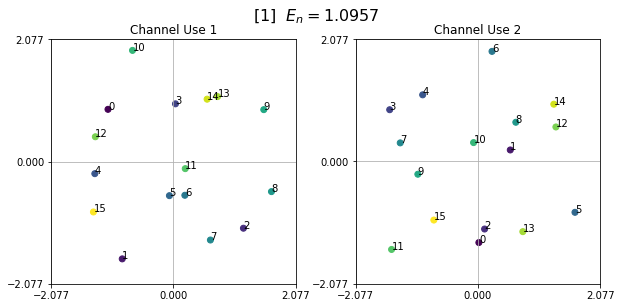

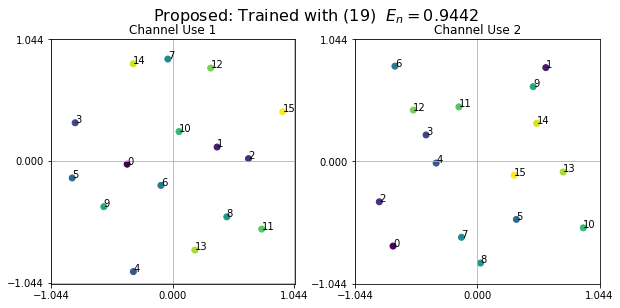

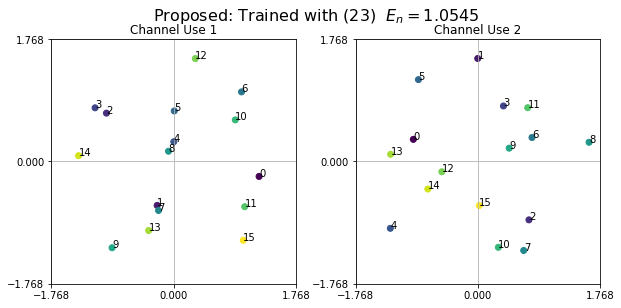

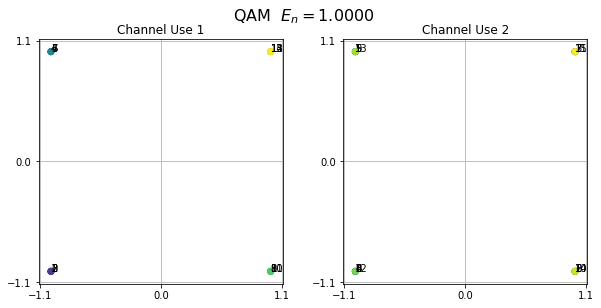

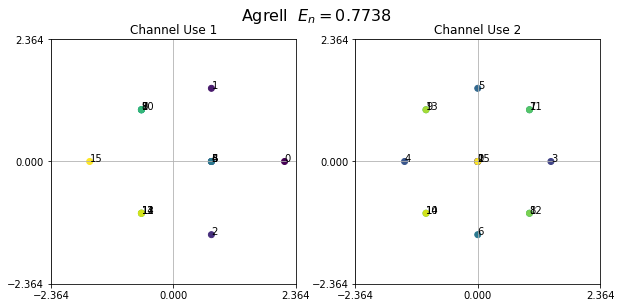

In [22]:
for (model_exp,density_data) in results.items():
    file_prefix = model_summary[model_exp].split("_summary.dil")[0]
    modelid = min(density_data, key=density_data.get)
    config_file = file_prefix + "_" + modelid + ".dil"
    config = {}
    model = None
    with open(config_file, "rb") as cfg_file:
        config = dill.load(cfg_file)
    if 'obj_fn' in config:    # obj_fn is there only for proposed CommVAE
        model = CommVAE1hot()
    else:
        model = AEOshea1hot()
    model.load_model(file_prefix+"_"+modelid)
    # Compute TX Map
    dl_map = model.encode(one_hot_code)
    max_mag = np.max(np.abs(dl_map))
    tick_points = [ -1.1*max_mag, 0.0, +1.1*max_mag ]
    # Plot TX Map
    fig, ax = plt.subplots(1, chDim, figsize=(5*chDim,4.5))
    for i in range(chDim):
        _ax = ax if chDim==1 else ax[i]
        _ax.scatter(dl_map[:,i],dl_map[:,i+chDim],c=np.arange(inVecDim))
        for j in range(inVecDim):
            _ax.annotate( j, (dl_map[j,i],dl_map[j,i+chDim]) )
        _ax.set_title( "Channel Use {}".format(i+1) )
        _ax.grid()
        _ax.set_xticks(tick_points)
        _ax.set_yticks(tick_points)
        _ax.set_aspect('equal')
    fig.suptitle("{}  $E_n={:5.4f}$".format(model_exp,density_data[modelid]), fontsize=16)
      
    # Clear Session and Model
    K.clear_session()
    del model
    
# Plot QAM Model
fig, ax = plt.subplots(1, chDim, figsize=(5*chDim,4.5))
max_mag = np.max(np.abs(qam_map))
tick_points = [ -1.1*max_mag, 0.0, +1.1*max_mag ]    
for i in range(chDim):
    _ax = ax if chDim==1 else ax[i]
    _ax.scatter(qam_map[:,2*i], qam_map[:,2*i+1], c=np.arange(inVecDim))
    for j in range(inVecDim):
        _ax.annotate( j, (qam_map[j,2*i],qam_map[j,2*i+1]) )
    _ax.set_title( "Channel Use {}".format(i+1) )
    _ax.grid()
    _ax.set_xticks(tick_points)
    _ax.set_yticks(tick_points)
    _ax.set_aspect('equal')
fig.suptitle("{}  $E_n={:5.4f}$".format("QAM",qam_en), fontsize=16)

# Plot Agrell Model
fig, ax = plt.subplots(1, chDim, figsize=(5*chDim,4.5))
max_mag = np.max(np.abs(agrell_map))
tick_points = [ -1.1*max_mag, 0.0, +1.1*max_mag ]    
for i in range(chDim):
    _ax = ax if chDim==1 else ax[i]
    _ax.scatter(agrell_map[:,2*i], agrell_map[:,2*i+1], c=np.arange(inVecDim))
    for j in range(inVecDim):
        _ax.annotate( j, (agrell_map[j,2*i],agrell_map[j,2*i+1]) )
    _ax.set_title( "Channel Use {}".format(i+1) )
    _ax.grid()
    _ax.set_xticks(tick_points)
    _ax.set_yticks(tick_points)
    _ax.set_aspect('equal')
fig.suptitle("{}  $E_n={:5.4f}$".format("Agrell",agrell_en), fontsize=16)